In [9]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
def show_results(data_dict, x_axis, title=None, xlabel=None, ylabel=None, loc=1):
    fig = plt.figure(figsize=(10,5))
    ax = fig.gca()
    ax.set_xticks(x_axis)
    plt.xlim(x_axis[0]-0.1, x_axis[-1]+0.1)
    if title is not None: plt.title(title)
    for label,data in data_dict.items():
        plt.plot(x_axis, data, 'o-', label=label)
    plt.legend(loc=loc)
    if xlabel is not None: plt.xlabel(xlabel)
    if ylabel is not None: plt.ylabel(ylabel)
    plt.grid()
    plt.show()

En esta sección se utilizaran modelos de Autoencoders en tres escenarios clásicos: reducción de dimensionalidad, denoising y pre-entrenamiento. La implementación será efectuada sobre un dataset denominado MNIST, una colección de 70.000 imágenes de 28 × 28 pixeles correspondientes a dígitos manuscritos (números entre 0 y 9). En su versión tradicional, la colección se encuentra separada en dos subconjuntos: uno de entrenamiento de 60.000 imágenes y otro de test de 10.000 imágenes. Es de nuestro interés entrenar un programa para que aprenda a identificar correctamente el dígito representado en la imagen.

*** a)*** Inicialmente se cargan los datos desde el repositorio de keras, y se normalizan las imágenes de modo que los pixeles queden en $[0, 1]$. Tal normalización permite interpretar cada valor como la probabilidad de que cada pixel sea activado.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
# Normalizacion de imagenes
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

Luego, se transforman las imágenes en vectores ($\in \mathbb{R}^{784}$) y se generan tres subconjuntos disjuntos: uno de entrenamiento, uno de validación y uno de pruebas. El conjunto de validación corresponde a los últimos 5000 casos del conjunto del entrenamiento.

In [4]:
# Transformación en vectores R^{784}
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Creación conjunto de validación
nval = 5000
x_val = x_train[-nval:]
y_val = y_train[-nval:]
x_train = x_train[:-nval]
y_train = y_train[:-nval]

# Transformación de salidas a probabilidades de activación
Y_train = np_utils.to_categorical(y_train, 10)
Y_val = np_utils.to_categorical(y_val, 10)
Y_test = np_utils.to_categorical(y_test, 10)

### 3.1 Reducción de Dimensionalidad

Una de las aplicaciones típicas de un AE es reducción de dimensionalidad, es decir, implementar una transformación $\phi: \mathbb{R}^d \rightarrow \mathbb{R}^{d'}$, con $d'<< d$ que preserve lo mejor posible la información original. Obtener tal representación es útil desde un punto de vista computacional (compresión) y estadístico (permite construir modelos con un
menor número de parámetros libres). Un AE es una técnica de reducción de dimensionalidad no supervisada porque no hace uso de información acerca de las clases a las que pertenecen los datos de entrenamiento.

*** a) *** A continuación, se entrena un AE básico (1 capa escondida) para generar una representación de MNIST en $d' = 2, 8, 32, 64$ dimensiones. Inicialmente se define un error cuadrático de reconstrucción ya que en secciones posteriores se requiere comparar los resultados con PCA, el cual no necesariamente mantiene sus predicciones en el intervalo  $[0,1]$ exigido para un error de reconstrucción binary cross entropy. Además, el uso de un error de reconstrucción binary cross entropy se consideraría un abuso del modelo ya que este se define en primera instancia para input $\in \{0,1\}$ y no necesariamente dentro de su intervalo. Cabe destacar, que tal error de recostrucción es sólo para efectos de evaluación de modelos, ya que la función de pérdida que efectivamente interviene durante el aprendizaje sí es binary cross entropy, como es habitual para casos de entrada dentro del intervalo $[0,1]$ con salidas independientes entre sí, deducido por el método de máxima verosimilitud.

In [12]:
def error_reconstruccion(x_test, x_decoded_test):
 
    error_reco = 0
    for l in range(len(x_test)): # para cada vector de prueba
        error = 0
        for i in range(len(x_test[0])): # para cada salida
            error += (x_test[l,i] - x_decoded_test[l,i])**2
    error_reco += error
    return error_reco/len(x_test)

Luego, se determina el porcentaje de comprensión obtenido y el error de reconstrucción en cada caso. Además se consideran los siguientes dos casos para las funciones de activación utilizadas:

_i) Encoder y decoder: Sigmoidal_

In [17]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD

input_img = Input(shape=(784,))

# Dimensiones
dim = np.array([2, 8, 32, 64])

# Para guardar los modelos
autoencoder = [None]*4
encoder = [None]*4
decoder = [None]*4
encoded_test = [None]*4
decoded_test = [None]*4
scores = np.empty(4)

for i in range(4):
    # AE para cada dimension
    encoded = Dense(dim[i], activation='sigmoid')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder[i] = Model(input=input_img, output=decoded)
    encoder[i] = Model(input=input_img, output=encoded)
    encoded_input = Input(shape=(dim[i],))
    decoder_layer = autoencoder[i].layers[-1]
    decoder[i] = Model(input=encoded_input, output=decoder_layer(encoded_input))
    autoencoder[i].compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder[i].fit(x_train, x_train, nb_epoch=50, batch_size=25, shuffle=True, verbose=0,validation_data=(x_val, x_val))
    encoded_test[i] = encoder[i].predict(x_test)
    decoded_test[i] = decoder[i].predict(encoded_test[i])
    error = error_reconstruccion(x_test, decoded_test[i])
    print ("d'= " + str(dim[i]))
    print ("Porcentaje de compresion: " + str(float(dim[i])*100/784) +" %")
    print ("Error de reconstruccion: " + str(error))
    print ('')
    autoencoder[i].save('basic_autoencoder_768x' + str(dim[i]) + '.h5')

C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_3, outputs=sigmoid.0)`
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_3, outputs=sigmoid.0)`
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_4, outputs=sigmoid.0)`
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:29: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


d'= 2
Porcentaje de compresion: 0.25510204081632654 %
Error de reconstruccion: 0.00776104132228



C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_5, outputs=sigmoid.0)`


d'= 8
Porcentaje de compresion: 1.0204081632653061 %
Error de reconstruccion: 0.00704934253329



C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_6, outputs=sigmoid.0)`


d'= 32
Porcentaje de compresion: 4.081632653061225 %
Error de reconstruccion: 0.00328040257189



C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_7, outputs=sigmoid.0)`


d'= 64
Porcentaje de compresion: 8.16326530612245 %
Error de reconstruccion: 0.00203037510476



_ii) Encoder: ReLu, decoder: Sigmoidal_

In [19]:
# IDEM pero con ReLu
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD

input_img = Input(shape=(784,))

# Dimensiones
dim = np.array([2, 8, 32, 64])

# Para guardar los modelos
r_autoencoder = [None]*4
r_encoder = [None]*4
r_decoder = [None]*4
r_encoded_test = [None]*4
r_decoded_test = [None]*4
r_scores = np.empty(4)

for i in range(4):
    # AE para cada dimension
    encoded = Dense(dim[i], activation='relu')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    r_autoencoder[i] = Model(input=input_img, output=decoded)
    r_encoder[i] = Model(input=input_img, output=encoded)
    encoded_input = Input(shape=(dim[i],))
    decoder_layer = r_autoencoder[i].layers[-1]
    r_decoder[i] = Model(input=encoded_input, output=decoder_layer(encoded_input))
    r_autoencoder[i].compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    r_autoencoder[i].fit(x_train,x_train,nb_epoch=50,batch_size=25,shuffle=True, #nb_epoch=50, batch_size=25
                    verbose=0,validation_data=(x_val, x_val))
    r_encoded_test[i] = r_encoder[i].predict(x_test)
    r_decoded_test[i] = r_decoder[i].predict(r_encoded_test[i])
    #scores[i] = autoencoder[i].evaluate(decoded_test[i], x_test, verbose=0)
    error = error_reconstruccion(x_test, r_decoded_test[i])
    print ("d'= " + str(dim[i]))
    print ("Porcentaje de compresion: " + str(float(dim[i])*100/784) +" %")
    print ("Error de reconstruccion: " + str(error))
    print ('')
    r_autoencoder[i].save('relu_basic_autoencoder_768x' + str(dim[i]) + '.h5')

C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_8, outputs=sigmoid.0)`
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_8, outputs=Elemwise{m...)`
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_9, outputs=sigmoid.0)`
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:30: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


d'= 2
Porcentaje de compresion: 0.25510204081632654 %
Error de reconstruccion: 0.00617615486544



C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_8, outputs=sigmoid.0)`
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_8, outputs=Elemwise{m...)`
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_10, outputs=sigmoid.0)`
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:30: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


d'= 8
Porcentaje de compresion: 1.0204081632653061 %
Error de reconstruccion: 0.00293794734278



C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_11, outputs=sigmoid.0)`


d'= 32
Porcentaje de compresion: 4.081632653061225 %
Error de reconstruccion: 0.00116055652994



C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_12, outputs=sigmoid.0)`


d'= 64
Porcentaje de compresion: 8.16326530612245 %
Error de reconstruccion: 0.00052300655125



A continuación se presenta un gráfico resumen de los resultados de error de reconstrucción obtenidos.

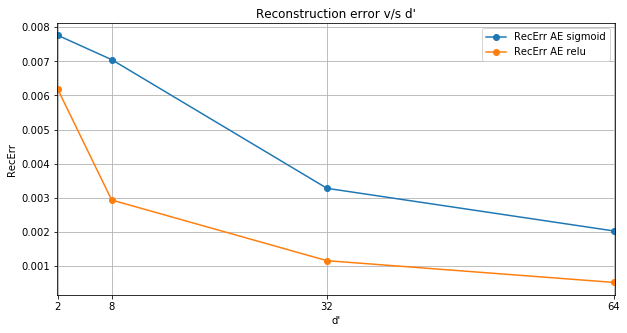

In [20]:
# Almacenando resultados en listas
rec_err_ae_sigmoid = [0.00776104132228, 0.00704934253329, 0.00328040257189, 0.00203037510476]
rec_err_ae_relu = [0.00617615486544, 0.00293794734278, 0.00116055652994, 0.00052300655125]

data_dict = {'RecErr AE sigmoid': rec_err_ae_sigmoid, 'RecErr AE relu':rec_err_ae_relu}
show_results(data_dict, [2,8,32,64], xlabel="d'", ylabel='RecErr', title="Reconstruction error v/s d'")

Como es de esperarse para ambos casos de función de activación del encoder, la capacidad de reconstrucción aumenta con valores de `d'` mayores, ya que las representaciones encontradas permiten conservar mayor información del patrón de entrada. Además, se evidencia una mejora significativa al cambiar la función de activación por `relu`, sugiriendo una mejor capacidad de representación en baja dimensionalidad. En general, el nivel de dispersión en las representaciones generadas por ReLu favorece la eficiencia al reproducir entradas con tamaños variables, esto debido a que variando el número de neuronas activas permite al modelo controlar la efectiva dimensionalidad de la representación para una imagen dada. En términos cuantitativos ambas funciones de activación ofrecen un bajo error de reconstrucción, sin embargo ReLu permite reducirlo a valores cercanos a la mitad de los obtenidos con Sigmoid. Notar que cuando la comprensión es muy alta ($d'=2$) las representaciones tienen menos capacidad de diferenciación entre sí, lo cual es rápidamente diluido al aumentar $d'$. Análogamente cuando la comprensión es despreciable, ambos errores (para cada función de activación) debiesen asemejarse dado lo poco restrictivo del encoder.

Con respecto al uso de ReLU para el decoder, no parece indicado dado el comportamiento ilimitado de la función para argumentos positivos, lo cual hiere la representación de pixeles normalizada al intervalo $[0,1]$. Además, la fuerte saturación en cero de ReLu, obliga a que cada vez que la red reconstruya un cero en vez de un valor correcto distinto de cero, dicha unidad de reconstrucción no podrá propagar ningún gradiente.

*** b)*** Ahora se verifica visualmente la calidad de las representaciones $\mathbb{R}^{d'}$ que logra hacer el autoencoder desde la representación en $\mathbb{R}^{d}$. Para esto se hace uso de las primeras diez imágenes del conjunto de pruebas.

_i) Encoder y decoder: Sigmoidal_

(10000, 2)
Reconstruccion para d'=2


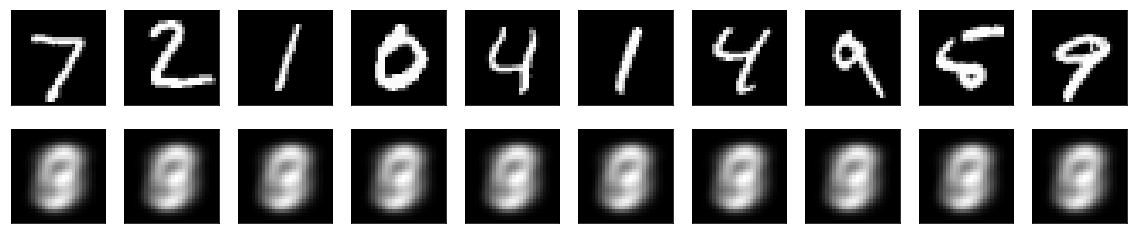

(10000, 8)
Reconstruccion para d'=8


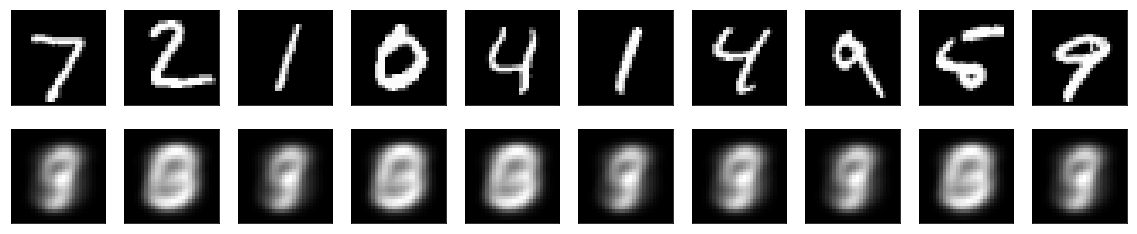

(10000, 32)
Reconstruccion para d'=32


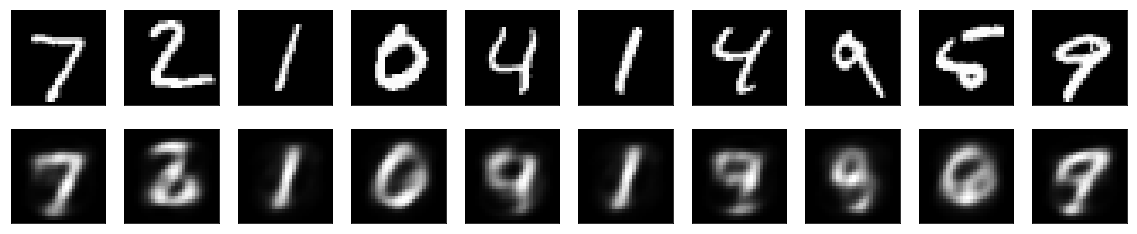

(10000, 64)
Reconstruccion para d'=64


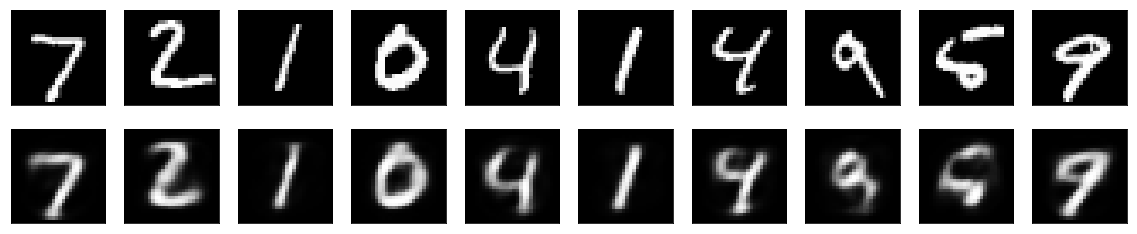

In [28]:
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline

# Load models

for j in range(4):
    autoencoder = load_model('basic_autoencoder_768x' + str(dim[j]) + '.h5')

    encoded_test = encoder[j].predict(x_test)
    decoded_test = decoder[j].predict(encoded_test)
    print(encoded_test.shape)

    # plots
    n = 10
    plt.figure(figsize=(20, 4))
    
    print ("Reconstruccion para d'=" + str(dim[j]))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

_ii) Encoder: ReLu, decoder: Sigmoidal_

(10000, 2)
Reconstruccion para d'=2


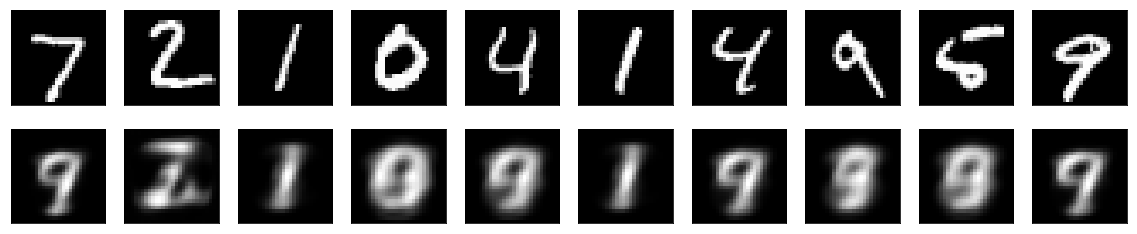

(10000, 8)
Reconstruccion para d'=8


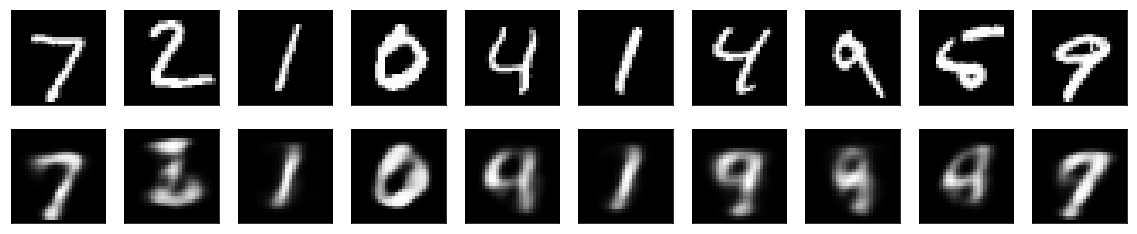

(10000, 32)
Reconstruccion para d'=32


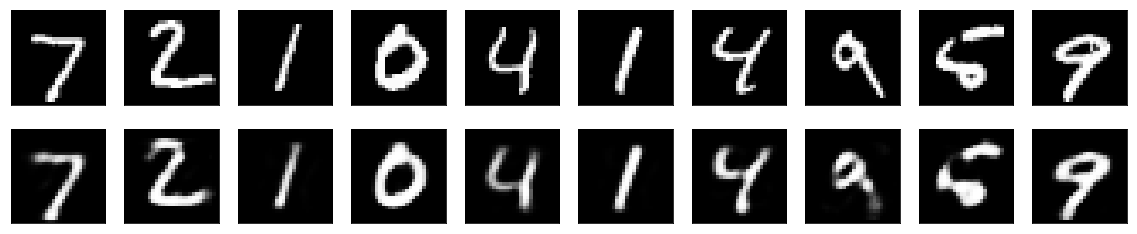

(10000, 64)
Reconstruccion para d'=64


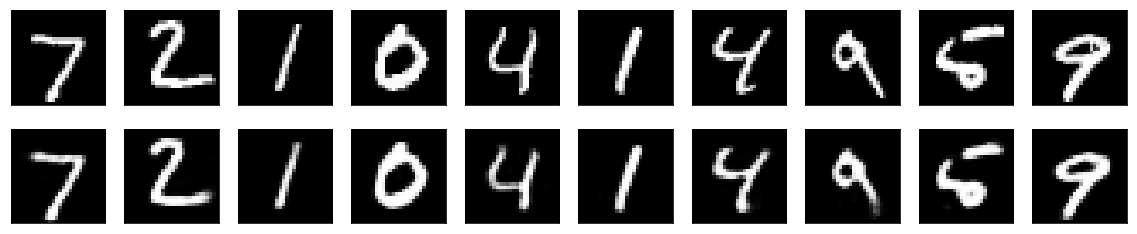

In [29]:
#IDEM pero con ReLu

from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline

# Load models

for j in range(4):
    autoencoder = load_model('relu_basic_autoencoder_768x' + str(dim[j]) + '.h5')
    encoded_test = r_encoder[j].predict(x_test)
    decoded_test = r_decoder[j].predict(encoded_test)
    print(encoded_test.shape)

    # plots
    n = 10
    plt.figure(figsize=(20, 4))
    
    print ("Reconstruccion para d'=" + str(dim[j]))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Así, se comprueba cualitativamente los resultados obtenidos en b). Se aprecia para ambas funciones de activación una fuerte mejoría al diminuir el porcentaje de comprensión. En cuanto a las diferencias observadas entre ReLu y Sigmoid, el mejor desempeño de la primera es evidenciado para $d'=8$ (donde cuantitativamente se produjo la mayor brecha en el error de reconocimiento), donde Sigmoid arroja representaciones irreconocibles, mientras que ReLu ya ofrece representaciones bastante precisas. Además, la diferencia de nitidez para $d'=64$ para ambas funciones es concluyente.

***c)*** Para verificar la calidad de la representación obtenida, se implementa el siguiente clasificador denominado $kNN$ (k-nearest neighbor): dada una imagen $\textbf{x}$, el clasificador busca las $k = 10$ imágenes de entrenamiento más similares $N_{\textbf{x}} = \{\textbf{x}^{(k_i)}\}^{10}_{i=1}$ (de acuerdo a una distancia, e.g. euclidiana) y predice como clase, la etiqueta más popular entre las imágenes $N_x$. Se crea la siguiente función para el calculo de accuracy y tiempo de las predicciones: 

In [42]:
from sklearn.neighbors import KNeighborsClassifier
import time
def knn_classification_accuracy(X_train, y_train, X_test, y_test):
    clf = KNeighborsClassifier(10)
    t0 = time.time()
    clf.fit(X_train, y_train)
    elapsed = time.time()-t0
    score = clf.score(X_test, y_test)
    print('Classification Accuracy: %.2f' % score)
    print('Elapsed time: {0}[s] \n'.format(elapsed))
    del clf
    return score

Para la data original (previa a la reducción):

In [44]:
print('Data original')
knn_classification_accuracy(x_train, y_train, x_test, y_test)

Data original
Classification Accuracy: 0.97
Elapsed time: 19.3941330909729[s] 



0.96589999999999998

Para las clasificaciones sobre la data reducida:

In [43]:
print('Sigmoid + d=2')
knn_classification_accuracy(encoder[0].predict(x_train), y_train, encoder[0].predict(x_test), y_test)

print('Sigmoid + d=8')
knn_classification_accuracy(encoder[1].predict(x_train), y_train, encoder[1].predict(x_test), y_test)

print('Sigmoid + d=32')
knn_classification_accuracy(encoder[2].predict(x_train), y_train, encoder[2].predict(x_test), y_test)

print('Sigmoid + d=64')
knn_classification_accuracy(encoder[3].predict(x_train), y_train, encoder[3].predict(x_test), y_test)

print('ReLU + d=2')
knn_classification_accuracy(r_encoder[0].predict(x_train), y_train, r_encoder[0].predict(x_test), y_test)

print('ReLU + d=8')
knn_classification_accuracy(r_encoder[1].predict(x_train), y_train, r_encoder[1].predict(x_test), y_test)

print('ReLU + d=32')
knn_classification_accuracy(r_encoder[2].predict(x_train), y_train, r_encoder[2].predict(x_test), y_test)

print('ReLU + d=64')
knn_classification_accuracy(r_encoder[3].predict(x_train), y_train, r_encoder[3].predict(x_test), y_test)

Sigmoid + d=2
Classification Accuracy: 0.15
Elapsed time: 0.46656107902526855[s] 

Sigmoid + d=8
Classification Accuracy: 0.31
Elapsed time: 0.11230182647705078[s] 

Sigmoid + d=32
Classification Accuracy: 0.87
Elapsed time: 0.20755958557128906[s] 

Sigmoid + d=64
Classification Accuracy: 0.96
Elapsed time: 0.4161336421966553[s] 

ReLU + d=2
Classification Accuracy: 0.42
Elapsed time: 0.0567317008972168[s] 

ReLU + d=8
Classification Accuracy: 0.89
Elapsed time: 0.08021664619445801[s] 

ReLU + d=32
Classification Accuracy: 0.96
Elapsed time: 0.22260022163391113[s] 

ReLU + d=64
Classification Accuracy: 0.96
Elapsed time: 0.4457972049713135[s] 



0.96350000000000002

Respecto de los tiempo de entrenamiento del clasificador kNN, se aprecia un aumento significativo al incrementar dimensionalidad de la data. Esto de debe a que kNN es un algoritmo de complejidad $O(ndk)$, siendo $k$ un hiperparámetro fijo, $n$ la cantidad de imágenes recibidas y $d$ la dimensionalidad de cada input, ya que requiere computar las distancias entre todos los ejemplos de entrenamiento, cálculo que es más complejo a mayor dimensionalidad. Así, es de esperarse que al considerar la data con dimensionalidad no reducida, el tiempo de clasificación es proporcionalmente mayor con respecto a las diferencias de dimensionalidades ($784-64$ en el caso más comparable).

Luego, se procede a graficar la accuracy de clasificación en función de la dimensionalidad exigida por el encoder:

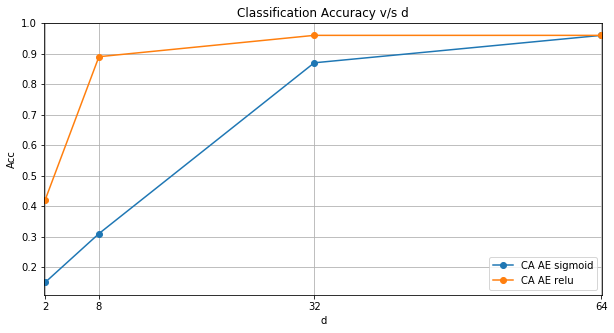

In [17]:
# Almacenando resultados en listas
ca_ae_sigmoid = [0.15, 0.31, 0.87, 0.96]
ca_ae_relu = [0.42, 0.89, 0.96, 0.96]
data_dict = {'CA AE sigmoid': ca_ae_sigmoid, 'CA AE relu':ca_ae_relu}
show_results(data_dict, [2,8,32,64], xlabel='d', ylabel='Acc', title='Classification Accuracy v/s d', loc=4)

Los resultados son consistentes a los obtenidos en secciones anteriores, donde la capacidad de clasificación significa representaciones generadas competentes, las cuales debiesen mejorar a medida que el patrón original se comprime en menor medida. Si bien ambas curvas alcanzan su máximo de presición en 0.96, la figura es concluyente sobre el mejor desempeño de ReLu en representaciones de baja dimensionalidad. Notar que la diferencia de accuracy entre una comprensión de dimensionalidad 64 y el input original de dimensionalidad 784 varían relativamente poco (en 0.01) comparado con la fuerte diferencia temporal en la clasificación, lo cual evidencia las representaciones idóneas generadas por los AE's.

*** d) *** Ahora se compara la calidad de la representación reducida obtenida por el autoencoder básico con aquella obtenida vía PCA utilizando el mismo número de dimensiones $d'=2,8,32,64$. Se considera como criterio de comparación el error de reconstrucción y desempeño en clasificación (vía kNN) de cada representación.

In [14]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

pca = [None]*4 # guardar modelos PCA
pca_train = [None]*4 # Guardar PCA train
pca_test = [None]*4 # Guardar PCA test
pca_decoded = [None]*4

# Dimensiones
dim = np.array([2, 8, 32, 64])

for i in range(4): # para cada dimension d'
    pca[i] = PCA(n_components=dim[i])
    pca[i].fit(x_train)
    pca_train[i] = pca[i].transform(x_train)
    pca_test[i] = pca[i].transform(x_test)
    pca_decoded[i] = pca[i].inverse_transform(pca_test[i])
    clf = KNeighborsClassifier(10)
    clf.fit(pca_train[i], y_train)
    score = clf.score(pca_test[i],y_test)
    error = error_reconstruccion(x_test, pca_decoded[i])
    
    print ("Representacion para d'=%.d" % dim[i])
 
    print ("Error de reconstruccion: " + str(error))
    print ('Classification Accuracy %.2f' % score)

    print ('')

Representacion para d'=2
Error de reconstruccion: 0.00609441194644
Classification Accuracy 0.44

Representacion para d'=8
Error de reconstruccion: 0.00280048892998
Classification Accuracy 0.90

Representacion para d'=32
Error de reconstruccion: 0.00189737605735
Classification Accuracy 0.97

Representacion para d'=64
Error de reconstruccion: 0.00102204343252
Classification Accuracy 0.97



- Error de reconstrucción:

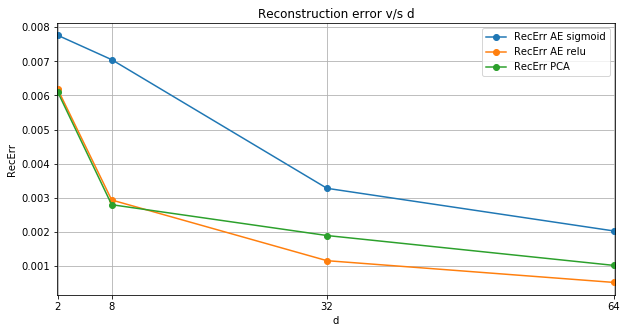

In [22]:
rec_err_pca = [0.00609441194644, 0.00280048892998, 0.00189737605735, 0.00102204343252]
data_dict = {'RecErr AE sigmoid': rec_err_ae_sigmoid, 'RecErr AE relu':rec_err_ae_relu, 'RecErr PCA':rec_err_pca}
show_results(data_dict, [2,8,32,64], xlabel='d', ylabel='RecErr', title='Reconstruction error v/s d')

Del gráfico se desprende que la capacidad de reconstrucción de PCA obtuvo mejores resultados que AE con Sigmoid, pero quedó por debajo del desempeño de ReLu al considerar dimensiones de representación mayores a $d'=32$. En cuanto a valores más pequeños de $d'$, la representación generada con PCA obtiene errores de reconstrucción incluso ligeramente menores a los obtenidos con el AE ReLu. Esto es bastante notable, teniendo en cuenta que PCA tan sólo realiza una transformación lineal sobre los datos, mientras que los AEs relizan transformaciones no lineales.

- Desempeño en clasificación:

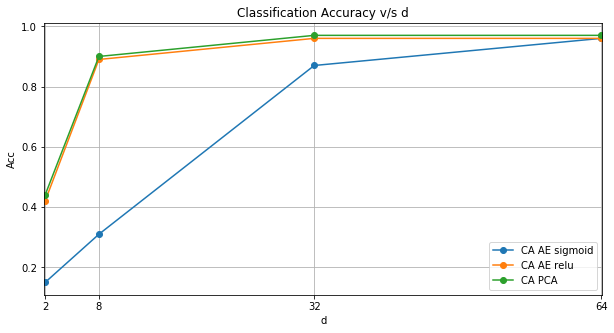

In [23]:
ca_pca = [0.44, 0.90, 0.97, 0.97] 
data_dict = {'CA AE sigmoid': ca_ae_sigmoid, 'CA AE relu':ca_ae_relu, 'CA PCA':ca_pca}
show_results(data_dict, [2,8,32,64], xlabel='d', ylabel='Acc', title='Classification Accuracy v/s d', loc=4)

En cuanto al proceso de clasificación vía kNN, la representación generada por PCA consigue un accuracy muy similar pero ligeramente mayor que AE con ReLu en todo valor de $d'$ estudiado, hasta llegar a un desempeño de predicción igual al encontrado con la data antes de ser reducida (accuracy: 0.97). Se entiende así, que el accuracy logrado por la representación del AE con Sigmoid es cómodamente superada con valores de $d'$ más restrictivos, condición equilibrada a medida que la dimensionalidad aumenta. 

Se destaca además que el tiempo invertido en el uso de PCA es mucho menor que cuando se prueban los autoencoders.

*** e) *** Ahora se modifica el autoencoder básico construido en a) para implementar un *deep autoencoder* (deep AE), es decir, un autoencoder con al menos dos capas ocultas. Esto con el fin de demostrar experimentalmente que este autoencoder puede mejorar significativamente la compresión obtenida por PCA utilizando el mismo número de dimensiones $d'$. Se expermienta con $d' = 2, 4, 8, 16, 32$ y distintas profundidades $(L = 2, 3, 4)$. Se utiliza solo activación ReLu en el encoder, ya que por razones de tiempo se privilegió aquella que hasta ahora a mostrado mejor desempeño. Nuevamente se considera como criterio de comparación el error de reconstrucción y desempeño en clasificación (vía kNN) de cada representación.

In [28]:
input_img = Input(shape=(784,))

import numpy

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

autoencoder4 = [None]*5
autoencoder3 = [None]*5
autoencoder2 = [None]*5
encoder4 = [None]*5
encoder3 = [None]*5
encoder2 = [None]*5
decoded_test4 = [None]*5
decoded_test3 = [None]*5
decoded_test2 = [None]*5
encoded_test4 = [None]*5
encoded_test3 = [None]*5
encoded_test2 = [None]*5
encoded_train4 = [None]*5
encoded_train3 = [None]*5
encoded_train2 = [None]*5

pca = [None]*5 
pca_train = [None]*5 
pca_test = [None]*5  
pca_decoded = [None]*5

for i in range(5):
    target_dim = 2**(i+1)
    
    encoded1 = Dense(1000, activation='relu')(input_img)
    encoded2 = Dense(500, activation='relu')(encoded1)
    encoded3 = Dense(250, activation='relu')(encoded2)
    encoded4 = Dense(target_dim, activation='relu')(encoded3)
    decoded4 = Dense(250, activation='relu')(encoded4)
    decoded3 = Dense(500, activation='relu')(encoded3)
    decoded2 = Dense(1000, activation='relu')(decoded3)
    decoded1 = Dense(784, activation='sigmoid')(decoded2)
    autoencoder4[i] = Model(input=input_img, output=decoded1)
    encoder4[i] = Model(input=input_img, output=encoded3)
    autoencoder4[i].compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder4[i].fit(x_train,x_train,nb_epoch=20,batch_size=25,shuffle=True,validation_data=(x_val, x_val), verbose=0)
    decoded_test4[i] = autoencoder4[i].predict(x_test)
    error = error_reconstruccion(x_test, decoded_test4[i])
    encoded_train4[i] = encoder4[i].predict(x_train)
    encoded_test4[i] = encoder4[i].predict(x_test)
    # Clasificador kNN
    from sklearn.neighbors import KNeighborsClassifier
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train4[i], y_train)
    scorekNN = clf.score(encoded_test4[i],y_test)
    print ("d'= " + str(target_dim) + " con 4 capas ocultas") 
    print ("Error de reconstruccion: " + str(error))
    print ('Classification Accuracy %.2f' % scorekNN) 
    print (" ")
    
    encoded1 = Dense(1000, activation='relu')(input_img)
    encoded2 = Dense(500, activation='relu')(encoded1)
    encoded4 = Dense(target_dim, activation='relu')(encoded2)
    decoded3 = Dense(500, activation='relu')(encoded4)
    decoded2 = Dense(1000, activation='relu')(decoded3)
    decoded1 = Dense(784, activation='sigmoid')(decoded2)
    autoencoder3[i] = Model(input=input_img, output=decoded1)
    encoder3[i] = Model(input=input_img, output=encoded2)
    autoencoder3[i].compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder3[i].fit(x_train,x_train,nb_epoch=20,batch_size=25,shuffle=True,validation_data=(x_val, x_val), verbose=0)
    decoded_test3[i] = autoencoder3[i].predict(x_test)
    error = error_reconstruccion(x_test, decoded_test3[i])
    encoded_train3[i] = encoder3[i].predict(x_train)
    encoded_test3[i] = encoder3[i].predict(x_test)
    # Clasificador kNN
    from sklearn.neighbors import KNeighborsClassifier
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train3[i], y_train)
    scorekNN = clf.score(encoded_test3[i],y_test)
    print ("d'= " + str(target_dim) + " con 3 capas ocultas") 
    print ("Error de reconstruccion: " + str(error))
    print ('Classification Accuracy %.2f' % scorekNN) 
    print (" ")
    
    encoded1 = Dense(1000, activation='relu')(input_img)
    encoded4 = Dense(target_dim, activation='relu')(encoded1)
    decoded2 = Dense(1000, activation='relu')(encoded4)
    decoded1 = Dense(784, activation='sigmoid')(decoded2)
    autoencoder2[i] = Model(input=input_img, output=decoded1)
    encoder2[i] = Model(input=input_img, output=encoded1)
    autoencoder2[i] = Model(input=input_img, output=decoded1)
    encoder2[i] = Model(input=input_img, output=encoded3)
    autoencoder2[i].compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder2[i].fit(x_train,x_train,nb_epoch=20,batch_size=25,shuffle=True,validation_data=(x_val, x_val), verbose=0)
    decoded_test2[i] = autoencoder2[i].predict(x_test)
    error = error_reconstruccion(x_test, decoded_test2[i])
    encoded_train2[i] = encoder2[i].predict(x_train)
    encoded_test2[i] = encoder2[i].predict(x_test)
    # Clasificador kNN
    from sklearn.neighbors import KNeighborsClassifier
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train2[i], y_train)
    scorekNN = clf.score(encoded_test2[i],y_test)
    print ("d'= " + str(target_dim) + " con 2 capas ocultas") 
    print ("Error de reconstruccion: " + str(error))
    print ('Classification Accuracy %.2f' % scorekNN) 
    print (" ")
    
    pca[i] = PCA(n_components=target_dim)
    pca[i].fit(x_train)
    pca_train[i] = pca[i].transform(x_train)
    pca_test[i] = pca[i].transform(x_test)
    pca_decoded[i] = pca[i].inverse_transform(pca_test[i])
    clf = KNeighborsClassifier(10)
    clf.fit(pca_train[i], y_train)
    score = clf.score(pca_test[i],y_test)
    error = error_reconstruccion(x_test, pca_decoded[i])
    print ("Representacion PCA para d'=%.d" % target_dim)
    print ("Error de reconstruccion: " + str(error))
    print ('Classification Accuracy %.2f' % score)
    print ('')

C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:40: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_2, outputs=sigmoid.0)`
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:41: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_2, outputs=Elemwise{m...)`
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:43: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


d'= 2 con 4 capas ocultas
Error de reconstruccion: 0.000487121992576
Classification Accuracy 0.97
 


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:64: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_2, outputs=sigmoid.0)`
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:65: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_2, outputs=Elemwise{m...)`
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:67: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


d'= 2 con 3 capas ocultas
Error de reconstruccion: 0.0039078474435
Classification Accuracy 0.92
 


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:86: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_2, outputs=sigmoid.0)`
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:87: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_2, outputs=Elemwise{m...)`
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:88: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_2, outputs=sigmoid.0)`
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:89: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_2, outputs=Elemwise{m...)`
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:91: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


d'= 2 con 2 capas ocultas
Error de reconstruccion: 0.00499643001335
Classification Accuracy 0.97
 
Representacion PCA para d'=2
Error de reconstruccion: 0.0060943942994
Classification Accuracy 0.44



C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:40: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_2, outputs=sigmoid.0)`
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:41: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_2, outputs=Elemwise{m...)`
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:43: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


d'= 4 con 4 capas ocultas
Error de reconstruccion: 0.000610392727038
Classification Accuracy 0.97
 
d'= 4 con 3 capas ocultas
Error de reconstruccion: 0.00275380790175
Classification Accuracy 0.94
 
d'= 4 con 2 capas ocultas
Error de reconstruccion: 0.00218255287115
Classification Accuracy 0.97
 
Representacion PCA para d'=4
Error de reconstruccion: 0.00427755649514
Classification Accuracy 0.64

d'= 8 con 4 capas ocultas
Error de reconstruccion: 0.00053531392638
Classification Accuracy 0.97
 
d'= 8 con 3 capas ocultas
Error de reconstruccion: 0.0012719846182
Classification Accuracy 0.96
 
d'= 8 con 2 capas ocultas
Error de reconstruccion: 0.00130909572334
Classification Accuracy 0.97
 
Representacion PCA para d'=8
Error de reconstruccion: 0.00279948081487
Classification Accuracy 0.90

d'= 16 con 4 capas ocultas
Error de reconstruccion: 0.000469686245258
Classification Accuracy 0.97
 
d'= 16 con 3 capas ocultas
Error de reconstruccion: 0.00113749076251
Classification Accuracy 0.98
 
d'=

- Error de reconstrucción:

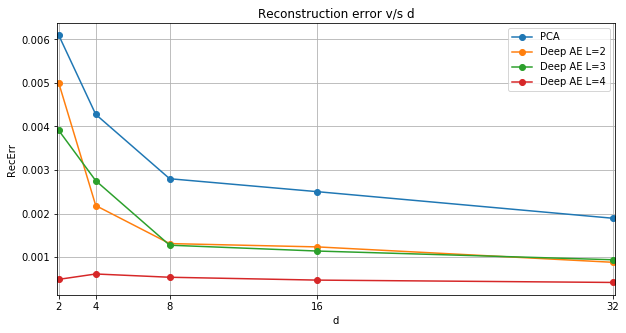

In [29]:
rec_err_dae_2L=[0.00499643001335, 0.00218255287115, 0.00130909572334, 0.00123277115973, 0.000878753908421]
rec_err_dae_3L=[0.0039078474435, 0.00275380790175, 0.0012719846182, 0.00113749076251,0.000937376116225]
rec_err_dae_4L=[0.000487121992576, 0.000610392727038, 0.00053531392638, 0.000469686245258, 0.000415916509379]
rec_err_pca=[0.0060943942994, 0.00427755649514, 0.00279948081487, 0.00250184787486, 0.00189068929]
data_dict = {'PCA': rec_err_pca, 'Deep AE L=2': rec_err_dae_2L, 'Deep AE L=3': rec_err_dae_3L, 'Deep AE L=4': rec_err_dae_4L}
show_results(data_dict, [2,4,8,16,32], xlabel='d', ylabel='RecErr', title='Reconstruction error v/s d')

Luego, es posible concluir empíricamente la superioridad de _deep AE's_ sobre PCA con respecto al error de reconstrucción cuadrático. PCA es superado en todas las dimensionalidades de representaciones y por todos los modelos _deep_ utilizados. Si bien, aumentar la cantidad de capas del AE no garantiza mejor calidad de las representaciones, en este caso si existe tendencia a este comportamiento, exceptuándo en algunos casos de ligera superioridad de $L=2$ por sobre $L=3$. Notar además, que ya para el AE más profundo $L=4$, una mayor comprensión no representa una penalización considerable en el error de reconstrucción, sugiriendo así, que AE profundos son capaces de generar ricas representaciones del patrón de entrada incluso a dimensionalidades muy restringidas (como $d'=2$). 

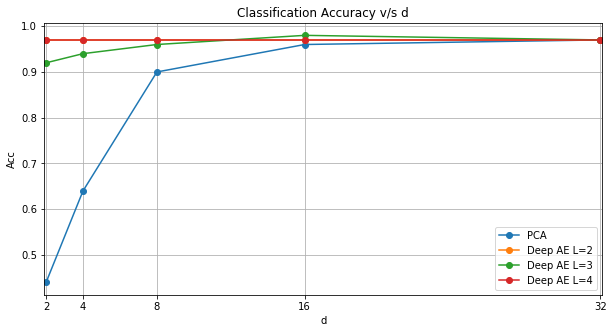

In [30]:
ca_dae_2L=[0.97, 0.97, 0.97, 0.97, 0.97]
ca_dae_3L=[0.92, 0.94, 0.96, 0.98, 0.97]
ca_dae_4L=[0.97, 0.97, 0.97, 0.97, 0.97]
ca_pca=[0.44, 0.64, 0.90, 0.96, 0.97]
data_dict = {'PCA': ca_pca, 'Deep AE L=2': ca_dae_2L, 'Deep AE L=3': ca_dae_3L, 'Deep AE L=4': ca_dae_4L}
show_results(data_dict, [2,4,8,16,32], xlabel='d', ylabel='Acc', title='Classification Accuracy v/s d', loc=4)

En cuanto al accuracy en clasificación, vuelven a encontrarse mejores desempeños para _deep's_ autoencoders por sobre representaciones obtenidas vía PCA. Con $L=2$ y $L=4$ se observan resultados similares (la curva naranja está bajo la roja). Para $L=3$ se consigue una pequeña diferencia de accuracy con el resto de sus semejantes para menores dimensiones, la cual es acortada en $d'=16$. Sin embargo, las brechas se vuelven considerables al comparar _deep's_ AE's con PCA en $d'=2$, $d'=4$ y $d'=8$, donde este último obtiene accuracy's de clasificación muy deficientes, las cuales recién resultan competitivas y comparables con  _deep's_ AE's en $d'=16$, desde donde las diferencias se reducen al encontrar representaciones del patrón de entrada de calidad similar.

***f)*** A continuación se visualizan las representaciones aprendidas anteriormente usando la herramienta TSNE disponible en la librería _sklearn_. Esta herramienta convierte similitudes entre puntos de datos a probabilidades conjuntas e intenta minimizar la divergencia de Kullback-Leibler entre dichas probabilidades conjuntas del _embedding_ de baja dimensión y los datos de alta dimensionalidad. Es de nuestro particular interés evidenciar las diferencias obtenidas por el _deep_ AE con $L=4$ y PCA al generar representaciones con $d'=2$ (por falta de recursos (GPU) no se prueba con más configuraciones).

In [6]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD

target_dim = 2 #try other and do a nice plot
input_img = Input(shape=(784,))
encoded1 = Dense(1000, activation='relu')(input_img)
encoded2 = Dense(500, activation='relu')(encoded1)
encoded3 = Dense(250, activation='relu')(encoded2)
encoded4 = Dense(target_dim, activation='relu')(encoded3)
decoded4 = Dense(250, activation='relu')(encoded4)
decoded3 = Dense(500, activation='relu')(encoded3)
decoded2 = Dense(1000, activation='relu')(decoded3)
decoded1 = Dense(784, activation='sigmoid')(decoded2)
autoencoder = Model(input=input_img, output=decoded1)
encoder = Model(input=input_img, output=encoded3)
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, nb_epoch=50, batch_size=25, shuffle=True, validation_data=(x_val, x_val), verbose=0)
autoencoder.save('denoise_768x1000x500x250x16.h5')

C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_2, outputs=sigmoid.0)`
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_2, outputs=Elemwise{m...)`
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


NameError: name 'error_reconstruccion' is not defined

_i) Visualización deep AE:_

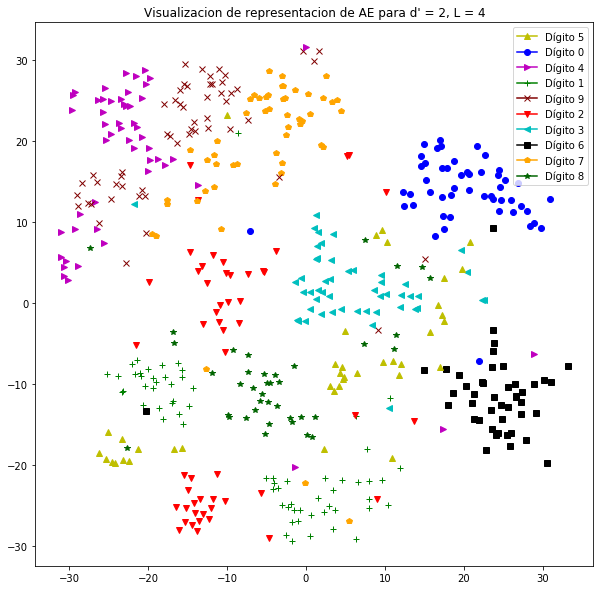

In [39]:
nplot=500
model = TSNE(n_components=2, random_state=0)

encoded_train = encoder.predict(x_train[:nplot])
encoded_train = model.fit_transform(encoded_train)
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
plt.figure(figsize=(10, 10))
plt.title("Visualizacion de representacion de AE para d' = 2, L = 4")
labels = [0,1,2,3,4,5,6,7,8,9]
for idx in range(0, nplot):
    label = y_train[idx]
    if label in labels:
        line = plt.plot(encoded_train[idx][0], encoded_train[idx][1], color=colors[label], marker=markers[label]
                        , markersize=6, label = "Dígito "+str(label))
        labels.remove(label)
    else:
        line = plt.plot(encoded_train[idx][0], encoded_train[idx][1], color=colors[label], marker=markers[label], markersize=6)
plt.legend(loc='upper right')
    
plt.show()

_ii) Visualización PCA:_

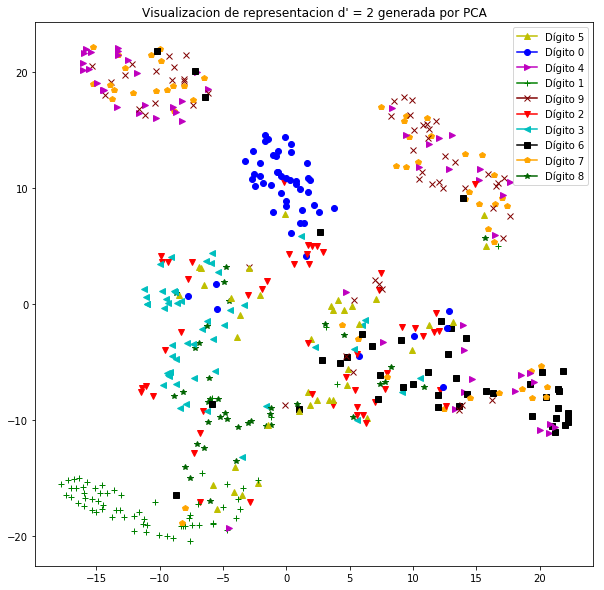

In [38]:
nplot = 500
# Se realiza reducción de dimensionalidad vía PCA
pca = PCA(n_components=2)
pca.fit(x_train[:nplot])
pca_train = pca.transform(x_train[:nplot])

# Se grafica representación
model = TSNE(n_components=2, random_state=0)
encoded_train = pca_train
encoded_train = model.fit_transform(pca_train)
plt.figure(figsize=(10, 10))
plt.title("Visualizacion de representacion d' = 2 generada por PCA")
labels = [0,1,2,3,4,5,6,7,8,9]
for idx in range(0, nplot):
    label = y_train[idx]
    if label in labels:
        line = plt.plot(encoded_train[idx][0], encoded_train[idx][1], color=colors[label], marker=markers[label]
                        , markersize=6, label = "Dígito "+str(label))
        labels.remove(label)
    else:
        line = plt.plot(encoded_train[idx][0], encoded_train[idx][1], color=colors[label], marker=markers[label], markersize=6)
plt.legend(loc='upper right')

plt.show()

Las diferencias cualitativas encontradas son bastante sugerentes. La formación de mejores clusters del caso _deep AE_, sobre un subconjunto de tamaño 500 del conjunto de entrenamiento, se interpreta como una mayor capacidad para representar el patrón de entrada en baja dimensionalidad ($d'=2$), lo cual ya había sido demostrado en secciones anteriores en base a criterios tradicionales. Resulta particularmente interesante los resultados arrojados por estas visualizaciones, ya que permite identificar aquellos dígitos que están siendo representados de mejor manera, y aquellos que significan mayor dificultad para el modelo. Para el caso _PCA_, se logra divisar un par de clusters aceptables correpondientes a los dígitos 0 y 1 en orden decreciente de calidad. Además, para esta misma representación, se evidencia la dificultad del modelo para diferenciar los dígitos 4, 7 y 9, los cuales tienden a ser agrupados conjuntamente. En cambio, un _AE_ con cuatro capas de profundidad, logra obtener separaciones entre cluster más evidentes, aunque sin gran cohesión entre sí (probablemente dado el carácter reducido del dataset utilizado). Aquellos dígitos que en el caso anterior eran malamente agrupados, son diferenciados de mejor manera por el _AE_, y aquellos dígitos que ni siquiera mostraban un patrón coherente en la representación obtenida por el _PCA_, ahora si es posible extraer características relevantes a pesar de su comprensión. 

***g)*** Finalmente se modifica el autoencoder construido en a) para trabajar directamente sobre las imágenes de MNIST, sin tratarlas como vectores de 784 atributos, sino como matrices de tamaño 1 x 28 x 28. Luego, obtenemos la representación adecuada del conjunto de imágenes:

In [5]:
x_train_ = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_val_ = np.reshape(x_val, (len(x_val), 28, 28, 1))
x_test_ = np.reshape(x_test, (len(x_test), 28, 28, 1))

Para llevar a cabo el objetivo, es preciso emplear capas convolucionales para definir el Encoder y el Decoder. El Encoder mantiene una arquitectura C x P x C x P, con 16 y 8 filtros convoluciones de tamaño 3 x 3 y 2 x 2 respectivamente, y capas _MaxPooling_ con filtros de tamaño 7 x 7 y 2 x 2 respectivamente. El Decoder, reconstruye simétricamente el patrón de entrada.

In [6]:
input_img = Input(shape=(28, 28, 1))

# Encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((7, 7), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same') (x)
encoded = MaxPooling2D((2, 2))(x)

# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((7, 7))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 8)           1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 8)           584       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 4, 4, 8)           0         
__________

In [ ]:
# Ejecutado en GPU
autoencoder.fit(x_train_, x_train_, epochs=50, batch_size=128, shuffle=True, verbose=0, validation_data=(x_val_, x_val_))
autoencoder.save('autoencoder_convolucional.h5')

El resumen muestra la propagación de los patrones de entrada a través del _deep_ autoencoder. Notar que la representación comprimida por el encoder presenta dimensiones (2, 2, 8), es decir, imágenes de 2 x 2 con 8 canales. De esta forma, la comparación pertinente respecto a los AE's utilizados con anterioridad, debe realizarse con aquel que arrojaba una representación de dimensionalidades equivalentes $d'= 32$.

Se procede a obtener el error de reconstrucción de la representación:

In [21]:
autoencoder = load_model('entrenamientos/3_1/autoencoder_convolucional.h5')

r_decoded_test = autoencoder.predict(x_test_)
error = error_reconstruccion(x_test_, r_decoded_test)
error_total=0
for i in error:
    error_total+=i
print ("Error de reconstrucción: " + str(error_total/len(error)))

Error de reconstrucción: [ 0.00015094]


La siguiente tabla resume los errores de reconstrucción obtenidos en toda la actividad para las representaciones con dimensionalidad $d'=32$ y función de activación _ReLu_ (o aquella obtenida con _PCA_). Por efectos de comprensión, se presenta en orden decreciente de calidad:

|Modelo|Error de reconstrucción|
|:------------:|:------------:|
|AE convolucional|0.00015094|
|AE L=4|0.000415916509379|
|AE L=2|0.000878753908421|
|AE L=3|0.000937376116225|
|PCA|0.00102204343252|
|AE básico|0.00116055652994|





Así, se concluye que las representaciones obtenidas sobre las imágenes MNIST son de mayor calidad cuando se trabaja directamente sobre el patrón de entrada. Se hipotetiza que modificar la estructura topológica original implica una pérdida de información, ya que sus caracteríticas podrían estar sujetas al vecindario en el cual se encuentran, donde un potencial cambio posicional acarrearía distintas (y menos precisas) representaciones. 